<h1 align="center">AI Assistants Intro</h1>

---

<center><h2>Lesson 04</h2></center>


#### **Intro to Supervised Machine Learning: Decision Trees + Workflow**

- Define supervised learning and its key pieces (features, labels, training).
- Explain classification vs regression.
- Describe decision trees and how they make decisions.
- Implement a decision tree in scikit-learn.
- Correctly do train/val/test splits and evaluate a simple model.


![Trolley cart decision scenario illustration](../../files/machine_learning_types.png)


### What is Supervised Learning?

Supervised learning pairs labeled examples with an algorithm that learns how to map inputs to outputs. Once trained, the model can make predictions on new, unseen data.

**Key pieces**

- **Dataset**: collection of examples we care about.
- **Features (`x`)**: measurable inputs like heart rate, pixels, or number of people on each track.
- **Labels (`y`)**: correct answers provided by humans, instruments, or previous experiments.
- **Model**: algorithm (decision tree, neural net, etc.) that learns a mapping from features to labels.
- **Training**: process of adjusting the model based on data so predictions get closer to true labels.
- **Evaluation**: how we score the model’s predictions (e.g., accuracy, mean squared error) to decide if it is good enough or needs improvement.

**Classification vs. regression**

- Classification predicts categories (e.g., "tumor is benign or malignant").
- Regression predicts continuous numbers (e.g., blood glucose level in mg/dL).

**The feedback loop**
Data → Model → Predictions → Compare to Labels → Learn → Repeat

**Check-your-understanding**

1. What makes learning “supervised”?
2. Is predicting blood glucose level classification or regression?


### The Titanic Example (Prediction as a Supervised Learning Problem)

We’ll use the classic **Titanic survival** dataset as a supervised learning problem.

We can frame it as supervised learning:

- **Inputs/features**: passenger info like class (`pclass`), sex, age, fare, and port of embarkation.
- **Output/label**: whether the passenger **survived** (`1`) or **did not survive** (`0`).
- This dataset is historical and widely used for teaching ML workflows (it is not a “fairness benchmark”).


### Dataset Preview

We’ll load the dataset into a DataFrame and inspect a few rows to understand the columns and missing values.


In the Titanic dataset, we’ll use a small set of human-readable features to predict survival:

- `pclass`: passenger class (1st, 2nd, 3rd).
- `sex`: passenger sex.
- `age`: passenger age (years; may have missing values).
- `sibsp`: number of siblings/spouses aboard.
- `parch`: number of parents/children aboard.
- `fare`: ticket price.
- `embarked`: port of embarkation (C/Q/S).

The label we want to predict is:

- `survived`: `1` if the passenger survived, `0` otherwise.


In [15]:
import pandas as pd
from sklearn.datasets import fetch_openml

# Load Titanic from OpenML as a pandas DataFrame
titanic = fetch_openml("titanic", version=1, as_frame=True)
df = titanic.frame.copy()

df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Decision trees break decisions into small yes/no questions until they reach a conclusion. A tiny (illustrative) tree for Titanic might look like:

```
Start
├─ Is sex == female? → Yes → Predict Survived
└─ No
   ├─ Is pclass == 1? → Yes → Predict Survived
   └─ No → Predict Did Not Survive
```

Each question corresponds to a split on one feature, and the final prediction is a **leaf node**.

**Check-your-understanding**

1. Which feature do you think a tree should split on first for Titanic? Why?
2. What does a “leaf” represent in a decision tree?


### ✏️ Exercise: Build a Simple Classifier by Hand (Titanic Heuristic)

Before we train a real model, we’ll build a tiny **rule-based baseline**. This mimics the idea of a decision tree split without doing any optimization.

**Rules (use these exactly in your code):**

1. If `sex == "female"`, predict `survived = 1`.
2. Else if `age < 15`, predict `survived = 1`.
3. Otherwise, predict `survived = 0`.

We’ll then compute the accuracy of this heuristic on the dataset.


In [20]:
# Implement the heuristic baseline from the prompt above

def predict_survival(row):
    sex = str(row.get("sex", "")).lower()
    age = pd.to_numeric(row.get("age", pd.NA), errors="coerce")

    if sex == "female":
        return 1
    if pd.notna(age) and float(age) < 15:
        return 1
    return 0

df["rule_pred"] = df.apply(predict_survival, axis=1)

# Ensure the label is numeric 0/1
y_true = pd.to_numeric(df["survived"], errors="coerce")
mask = y_true.notna()
rule_accuracy = (df.loc[mask, "rule_pred"] == y_true.loc[mask].astype(int)).mean()

print(f"Heuristic baseline accuracy (rows with non-missing label): {rule_accuracy:.2f}")
df[["survived", "sex", "age", "pclass", "rule_pred"]].head(10)

Heuristic baseline accuracy (rows with non-missing label): 0.78


,survived,sex,age,pclass,rule_pred
0,1,female,29.0000,1,1
1,1,male,0.9167,1,1
2,0,female,2.0000,1,1
3,0,male,30.0000,1,0
4,0,female,25.0000,1,1
5,1,male,48.0000,1,0
6,1,female,63.0000,1,1
7,0,male,39.0000,1,0
8,1,female,53.0000,1,1
9,0,male,71.0000,1,0


### ✏️ Exercise: Create a Synthetic Passenger Dataset (Using Your Heuristic)

In real ML, you sometimes **create labels** by applying a known policy or rule. In this exercise you’ll generate a small synthetic “Titanic-like” passenger table and label it using your `predict_survival(...)` heuristic.

**Your task**

Create a DataFrame with **at least 200 rows** and these columns:

- `passenger_id` (unique integer id)
- `pclass` (1/2/3)
- `sex` ("male"/"female")
- `age` (float)
- `sibsp` (integer)
- `parch` (integer)
- `fare` (float)
- `embarked` ("C"/"Q"/"S")
- `survived` (label: `0` or `1`)

**Rules for the label**

- You must compute `survived` by calling your `predict_survival(...)` function from the previous exercise.
- Do not manually type labels.

**Checks (do these at the end)**

1. Show `df_synth.head()`
2. Print the class balance: `df_synth["survived"].value_counts(normalize=True)`
3. Sanity-check a few rows by recomputing `predict_survival(...)` and confirming it matches `survived`.


In [17]:
import numpy as np
import pandas as pd

# Pick dataset size
N = 300
rng = np.random.default_rng(0)

df_synth = pd.DataFrame(
    {
        "passenger_id": np.arange(1, N + 1),
        "pclass": rng.integers(1, 4, size=N),
        "sex": rng.choice(["male", "female"], size=N, replace=True),
        "age": rng.uniform(0, 80, size=N).round(1),
        "sibsp": rng.integers(0, 6, size=N),
        "parch": rng.integers(0, 6, size=N),
        "fare": rng.uniform(0, 250, size=N).round(2),
        "embarked": rng.choice(["C", "Q", "S"], size=N, replace=True),
    }
)

# Create labels using YOUR heuristic function from the previous exercise
df_synth["survived"] = df_synth.apply(predict_survival, axis=1)

display(df_synth.head())
print("Class balance:")
display(df_synth["survived"].value_counts(normalize=True))

# Sanity-check a few rows
sample_rows = df_synth.sample(5, random_state=0)
sample_rows = sample_rows.assign(rule_check=sample_rows.apply(predict_survival, axis=1))
display(sample_rows[["passenger_id", "survived", "rule_check"]])
assert (sample_rows["survived"] == sample_rows["rule_check"]).all()

,passenger_id,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,1,3,male,71.7,3,4,235.24,Q,0
1,2,2,male,46.7,0,1,137.65,C,0
2,3,2,male,3.2,2,1,230.40,C,1
3,4,1,male,56.9,4,4,84.14,Q,0
4,5,1,male,45.5,5,1,191.08,C,0


Class balance:


survived
1    0.586667
0    0.413333
Name: proportion, dtype: float64

,passenger_id,survived,rule_check
208,209,0,0
188,189,1,1
12,13,1,1
221,222,1,1
239,240,0,0


This tiny heuristic is a baseline, but it will miss many patterns and interactions in the data. Rather than hand-coding every rule, we let ML algorithms search through many possible splits and automatically build trees with a consistent strategy.


### Create a Decision Tree Classifier

`scikit-learn` is a widely used Python library that standardizes ML workflows. The pattern is predictable:

1. Import the model class.
2. Create a model instance (optionally set hyperparameters).
3. Fit on training data (learn patterns).
4. Predict on data.
5. Evaluate with a metric such as accuracy.


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [19]:
# Minimal Titanic preprocessing: select features, handle missing values, one-hot encode categoricals
feature_cols = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]

df_model = df[feature_cols + ["survived"]].copy()

# Coerce numerics
for col in ["age", "fare", "sibsp", "parch", "pclass", "survived"]:
    df_model[col] = pd.to_numeric(df_model[col], errors="coerce")

# Drop rows with missing label
df_model = df_model.dropna(subset=["survived"]).copy()
df_model["survived"] = df_model["survived"].astype(int)

# Simple imputations
df_model["sex"] = df_model["sex"].fillna("unknown")
df_model["embarked"] = df_model["embarked"].fillna(df_model["embarked"].mode(dropna=True)[0])
df_model["age"] = df_model["age"].fillna(df_model["age"].median())
df_model["fare"] = df_model["fare"].fillna(df_model["fare"].median())

X = pd.get_dummies(df_model[feature_cols], columns=["sex", "embarked"], dummy_na=False)
y = df_model["survived"]

print("X shape:", X.shape)
X.head()

TypeError: Cannot setitem on a Categorical with a new category (unknown), set the categories first

In [ ]:
demo_tree = DecisionTreeClassifier(random_state=0, max_depth=3)
demo_tree.fit(X, y)
demo_preds = demo_tree.predict(X)
demo_acc = accuracy_score(y, demo_preds)
print(f"Demo tree accuracy on the same data: {demo_acc:.2f}")

Demo tree accuracy on the same data: 0.95


**Why not celebrate yet?** Training and evaluating on the same data can hide overfitting. A deep tree can memorize every row (100% accuracy) but fail on new scenarios. To know how a model will generalize, we need to hold out data the model never sees during training.


### Train / Validation / Test Splits

- **Training set**: used to learn the model parameters.
- **Validation set**: used to tune choices like tree depth or learning rate without touching the test set.
- **Test set**: only used once, at the end, to estimate performance on truly unseen data.

A common recipe is 70% train, 15% validation, 15% test (ratios vary). Guard against **data leakage**, which happens when information from the validation or test set sneaks into training—this makes the model look better than it really is.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.4,
    random_state=42,
    stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)
print(f"Train size: {len(X_train)} rows")
print(f"Validation size: {len(X_val)} rows")
print(f"Test size: {len(X_test)} rows")

Train size: 12 rows
Validation size: 4 rows
Test size: 4 rows


In [ ]:
titanic_tree = DecisionTreeClassifier(random_state=42, max_depth=3)
titanic_tree.fit(X_train, y_train)
train_acc = accuracy_score(y_train, titanic_tree.predict(X_train))
val_acc = accuracy_score(y_val, titanic_tree.predict(X_val))
test_acc = accuracy_score(y_test, titanic_tree.predict(X_test))

pd.DataFrame(
    {
        "Split": ["Train", "Validation", "Test"],
        "Accuracy": [train_acc, val_acc, test_acc]
    }
)

,Split,Accuracy
0,Train,1.00
1,Validation,0.75
2,Test,0.75


**Reflection prompt:** If your validation accuracy is much higher than test accuracy, what might be happening? How would you investigate it?


### Visualizing the Decision Tree

Decision trees are popular because they are interpretable: you can literally see each split and explain predictions to teammates. Visualizing the trained tree helps confirm whether the splits match our intuition.


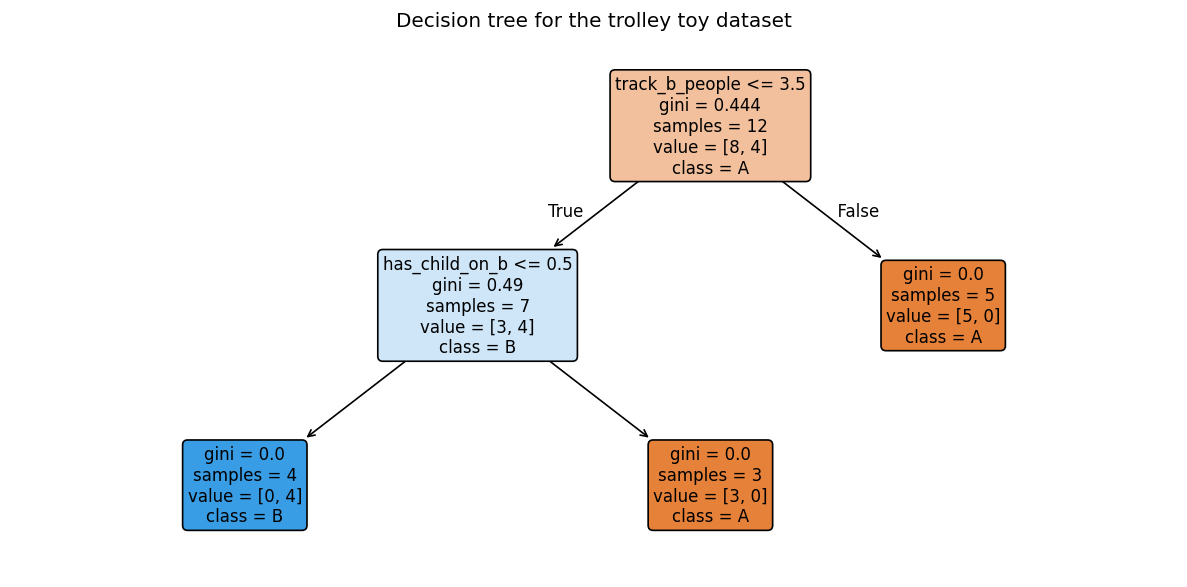

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(12, 6), dpi=120)
tree.plot_tree(
    titanic_tree,
    feature_names=list(X.columns),
    class_names=["died (0)", "survived (1)"],
    filled=True,
    rounded=True,
    fontsize=9
)
plt.title("Decision tree for the Titanic dataset")
plt.tight_layout()
plt.show()

### Interpreting Gini and the Diagram

- **Gini impurity** measures how mixed the labels are in a node: $G = 1 - \sum_k p_k^2$, where $p_k$ is the fraction of samples from class $k$. A pure node (all `0` or all `1`) has $G = 0$.
- Each box shows: the split rule, the impurity (`gini`), how many samples reach that node (`samples`), the class counts (`value`), and the predicted class (`class`).
- Reading the tree top to bottom mirrors the decision process: start at the root question, follow the branch that matches a passenger’s features, and stop at a leaf to see the final prediction.


## A Classic Dataset! (Iris Dataset)

To build confidence, let’s repeat the same workflow on the classic Iris flower dataset included in scikit-learn. The steps—split, train, validate, test—stay the same regardless of dataset size.
The Iris dataset is a classic multivariate dataset containing **150 iris flowers** from **three species**:

- _setosa_ (label `0`)
- _versicolor_ (label `1`)
- _virginica_ (label `2`)

Each row corresponds to a **single flower** and includes **four numeric features** (all in centimeters):

- `sepal length (cm)`
- `sepal width (cm)`
- `petal length (cm)`
- `petal width (cm)`

In scikit-learn, the dataset is provided as a `Bunch` object with:

- `data`: a `(150, 4)` feature matrix (`X_iris`)
- `target`: a length‑150 vector of integer labels (`y_iris`)
- `feature_names`: list of the four feature names
- `target_names`: array mapping `0, 1, 2` → `"setosa"`, `"versicolor"`, `"virginica"`

In this notebook, we:

- Built a **scatter-matrix** (`fig`) to visualize how the three species separate across pairs of features.
- Split the data into **train**, **validation**, and **test** sets (`X_train_i`, `X_val_i`, `X_test_i`, etc.).
- Trained a **DecisionTreeClassifier** (`iris_tree`) and evaluated it with accuracy on each split.
- Computed a **confusion matrix** (`iris_cm`) to see how well the model distinguishes the three species; the current tree achieves **near-perfect (in our run, perfect) accuracy** on the test set.

Because it is small, clean, and well-behaved (no missing values, balanced classes, simple numeric features), the Iris dataset is ideal for practicing supervised learning workflows: **split → train → validate → test**, interpreting decision trees, and comparing different classifiers.


![Iris Flowers Feature illustration](../../files/iris-flowers.png)


In [ ]:
import plotly.express as px
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
X_iris = iris.data
y_iris = iris.target

iris_df = iris.frame.copy()
iris_df["species"] = iris_df["target"].map(lambda idx: iris.target_names[idx])

fig = px.scatter_matrix(
  iris_df,
  dimensions=iris.feature_names,
  color="species",
  title="Iris dataset feature relationships",
  labels={col: col.replace(" (cm)", "") for col in iris.feature_names}
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
X_iris = iris.data
y_iris = iris.target

X_train_i, X_temp_i, y_train_i, y_temp_i = train_test_split(
    X_iris, y_iris, test_size=0.4, random_state=0, stratify=y_iris
)
X_val_i, X_test_i, y_val_i, y_test_i = train_test_split(
    X_temp_i, y_temp_i, test_size=0.5, random_state=0, stratify=y_temp_i
)

iris_tree = DecisionTreeClassifier(random_state=0, max_depth=3)
iris_tree.fit(X_train_i, y_train_i)

iris_train_acc = accuracy_score(y_train_i, iris_tree.predict(X_train_i))
iris_val_acc = accuracy_score(y_val_i, iris_tree.predict(X_val_i))
iris_test_acc = accuracy_score(y_test_i, iris_tree.predict(X_test_i))

pd.DataFrame(
    {
        "Split": ["Train", "Validation", "Test"],
        "Accuracy": [iris_train_acc, iris_val_acc, iris_test_acc]
    }
)

,Split,Accuracy
0,Train,0.977778
1,Validation,0.966667
2,Test,1.000000


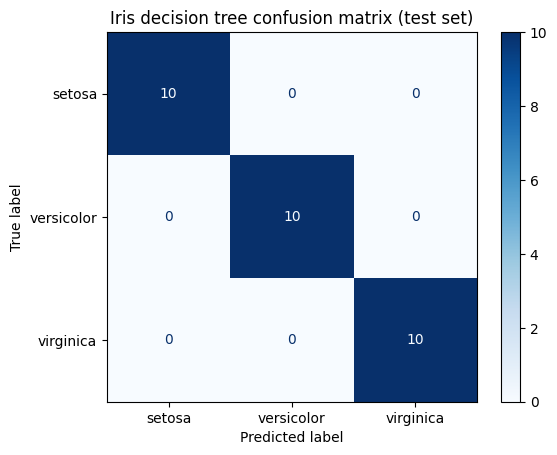

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

iris_cm = confusion_matrix(y_test_i, iris_tree.predict(X_test_i))
disp = ConfusionMatrixDisplay(
    confusion_matrix=iris_cm, display_labels=iris.target_names
)
disp.plot(cmap="Blues")
plt.title("Iris decision tree confusion matrix (test set)")
plt.show()

### Mini-Assignment

1. Add 1–2 new features to the trolley dataset (ideas: `is_night`, `has_obstacle_on_b`) and briefly justify how they could influence a decision. Re-train the tree and describe any changes you observe.
2. Re-train the decision tree with at least two different `max_depth` values (e.g., 2 vs. 5) and compare validation accuracy. Which depth would you keep and why?
3. In 3–5 sentences, explain why we keep the test set untouched until the end and what could go wrong if we peek at it early.

**Stretch goal:** Try a different classifier (e.g., logistic regression) on the trolley data and compare its validation/test accuracy with the tree.
